#Import data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt #We will use this package to make plots
all = pd.read_csv("/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/combined_all_new.csv")
#drop missing values and duplicate
combined_all=all.dropna()
combined_all=combined_all.drop_duplicates()
# Remove decimals by converting 'Year' to an integer type
combined_all['Year'] = combined_all['Year'].astype(int)

In [ ]:
#see the number of comments per year
comments= combined_all[['Comment', 'Year']].groupby(by="Year").count()
comments.head(15)

Comment
Year         
2017     3751
2018     4151
2019     7683
2020     4514
2021     9688
2022     4618
2023     3428
2024     4498

#Visualization of the dataset

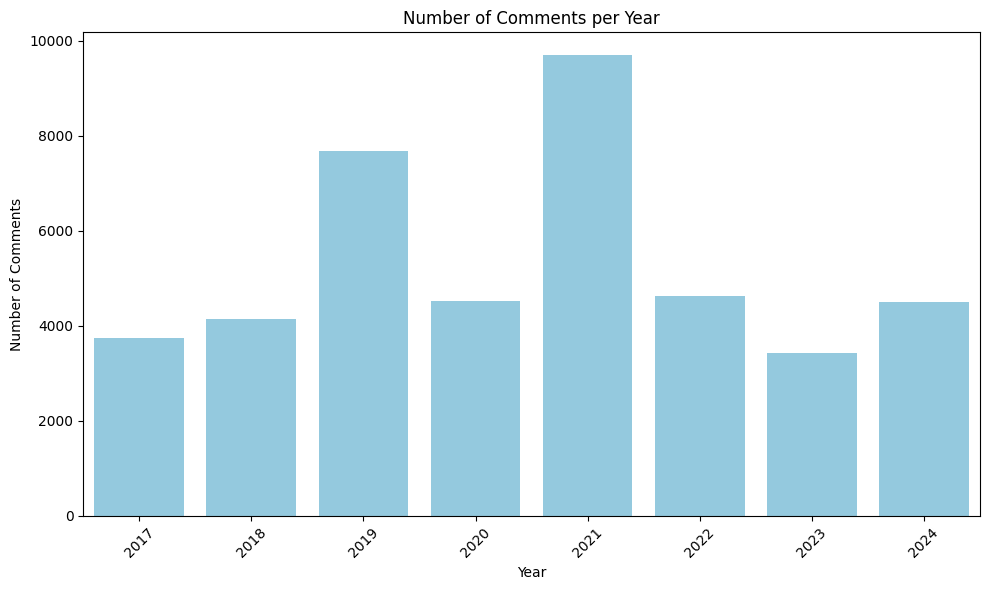

In [ ]:
#Number of comments per year
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'comments' contains the count of comments per year
plt.figure(figsize=(10, 6))
sns.barplot(x=comments.index, y=comments['Comment'], color='skyblue')

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Number of Comments per Year')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.savefig('comments_per_year.png', format='png', dpi=300)  # Save with high resolution
# Show the plot
plt.show()

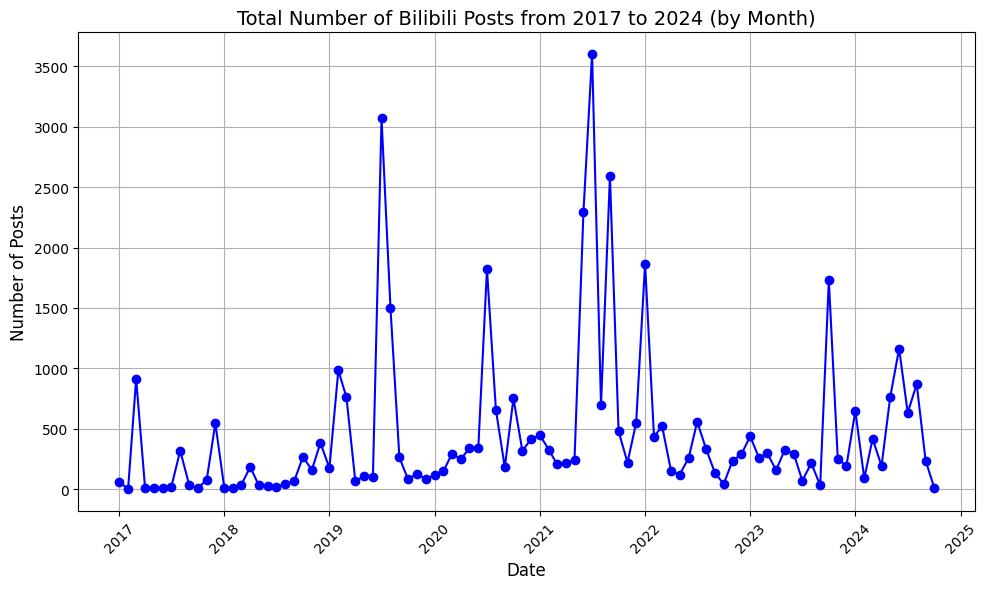

In [ ]:
#Time of the posts
# Assume the dataset contains a 'PostDate' column that stores the date each post was published.
# Ensure the date column is parsed as a datetime type.
combined_all['Time'] = pd.to_datetime(combined_all['Time'], errors='coerce')

# Remove rows with invalid dates.
combined_all = combined_all.dropna(subset=['Time'])

# Group the data by year and month, and count the number of posts per month.
monthly_posts = combined_all.groupby(combined_all['Time'].dt.to_period('M')).size()

# Reset the index to make it easier to plot.
monthly_posts = monthly_posts.reset_index(name='TotalPosts')

# Convert the Period type to datetime type for plotting.
monthly_posts['Time'] = monthly_posts['Time'].dt.to_timestamp()

# Plot a line chart.
plt.figure(figsize=(10, 6))
plt.plot(monthly_posts['Time'], monthly_posts['TotalPosts'], marker='o', linestyle='-', color='b')

# Add a title and labels.
plt.title('Total Number of Bilibili Posts from 2017 to 2024 (by Month)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)

# Set the x-axis tick format.
plt.xticks(rotation=45)
plt.grid(True)

# Display the chart.
plt.tight_layout()
plt.show()


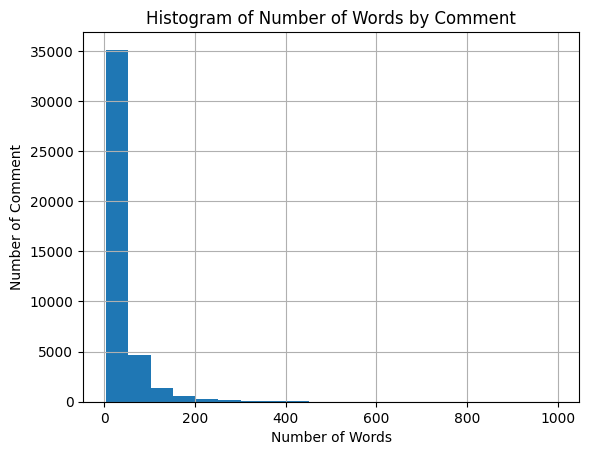

In [ ]:
#How many words each comment contains?
combined_all['len']=combined_all['Comment'].str.split("").str.len()
combined_all['len'].hist(bins=20)
plt.title('Histogram of Number of Words by Comment')
plt.xlabel('Number of Words')
plt.ylabel('Number of Comment')
plt.show()

#Topic modeling, LDA

In [ ]:
#use all data to create topics
df2=combined_all

In [ ]:
!pip install --force-reinstall scipy==1.10.1 numpy==1.24.4 gensim==4.3.1

In [ ]:
from gensim import corpora, models


In [ ]:
#vectorize
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba
import pandas as pd
import os
from gensim import corpora, models
# read list of stop words
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

# the directory to the dictionary of stop words
stopwords_file = "/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/font/哈工大停用词表.txt"  # 替换为实际的停顿词文件路径
stopwords = load_stopwords(stopwords_file)

# combine all comments to string
df2_comments = ' '.join(df2['Comment'].astype(str))

# use jieba to tokenize
segmented_text_df2 = jieba.cut(df2_comments)
texts = [list(jieba.cut(comment)) for comment in df2['Comment'].astype(str)]

# remove stop words
filtered_words_df2 = [word for word in segmented_text_df2 if word not in stopwords and len(word.strip()) > 0]
# Tokenize each document (split into words)
filtered_words_tokenized_df2 = [doc.split() for doc in filtered_words_df2]
filtered_documents_df2 = [
    [word for word in document if word not in stopwords and len(word.strip()) > 0]
    for document in filtered_words_tokenized_df2
]
# Now create the dictionary
dictionary= corpora.Dictionary(filtered_documents_df2)
# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=0.001, no_above=0.90, keep_n=10000)


dictionary.compactify()

# Convert document into a bag of word, following gensim package
corpus = [dictionary.doc2bow(text) for text in texts]

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.cache
Loading model cost 2.057 seconds.
DEBUG:jieba:Loading model cost 2.057 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


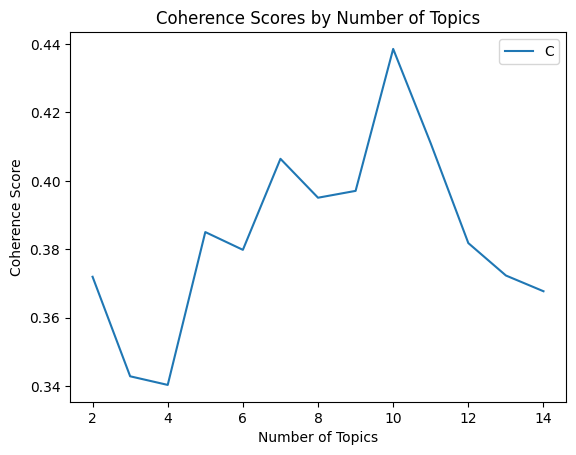

Optimal number of topics: 10
Num Topics = 2, Coherence Value = 0.372
Num Topics = 3, Coherence Value = 0.3429
Num Topics = 4, Coherence Value = 0.3404
Num Topics = 5, Coherence Value = 0.385
Num Topics = 6, Coherence Value = 0.3798
Num Topics = 7, Coherence Value = 0.4065
Num Topics = 8, Coherence Value = 0.3951
Num Topics = 9, Coherence Value = 0.3971
Num Topics = 10, Coherence Value = 0.4386
Num Topics = 11, Coherence Value = 0.411
Num Topics = 12, Coherence Value = 0.3818
Num Topics = 13, Coherence Value = 0.3723
Num Topics = 14, Coherence Value = 0.3677


In [ ]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Calculate coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1, random_state=42): # When the random seed is 42
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Adjust the number of topics to observe perplexity and coherence under different topic numbers
limit = 15
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(dictionary, corpus, texts, limit, start, step)

# Plot the coherence score curve
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend("Coherence Values", loc='best')
plt.title("Coherence Scores by Number of Topics")
plt.show()

# Select the number of topics with the highest coherence score
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Print the coherence scores for each number of topics
for num_topics, coherence_value in zip(x, coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Value = {round(coherence_value, 4)}")


In [ ]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import re
num_topics = 8
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.065*"孩子" + 0.027*"吃瓜" + 0.023*"抑郁症" + 0.009*"无" + 0.008*"好好" + 0.008*"喜极而泣" + 0.008*"好" + 0.008*"回" + 0.008*"动画" + 0.007*"中"')
(1, '0.014*"穿" + 0.011*"日本" + 0.010*"月" + 0.008*"滑稽" + 0.008*"抄袭" + 0.008*"西方" + 0.007*"岁" + 0.007*"call" + 0.007*"️" + 0.007*"关注"')
(2, '0.023*"国外" + 0.023*"中国" + 0.022*"回来" + 0.021*"国内" + 0.017*"留学" + 0.016*"支教" + 0.015*"工作" + 0.013*"生活" + 0.012*"好" + 0.011*"找"')
(3, '0.026*"美国" + 0.016*"钱" + 0.014*"海龟" + 0.013*"有钱" + 0.009*"好" + 0.007*"高" + 0.006*"花" + 0.006*"up" + 0.006*"生活" + 0.005*"发展"')
(4, '0.019*"视频" + 0.018*"眼睛" + 0.017*"辣" + 0.014*"脱单" + 0.014*"苦" + 0.013*"藏狐" + 0.010*"学生" + 0.009*"公司" + 0.008*"拍" + 0.008*"问题"')
(5, '0.036*"笑" + 0.030*"哭" + 0.020*"中文" + 0.020*"英文" + 0.018*"英语" + 0.011*"知道" + 0.010*"学" + 0.008*"专业" + 0.008*"说话" + 0.007*"装"')
(6, '0.032*"老师" + 0.012*"妙" + 0.011*"本科" + 0.010*"博士" + 0.010*"硕士" + 0.010*"抄" + 0.009*"医院" + 0.009*"毕业" + 0.008*"北京" + 0.007*"以为"')
(7, '0.019*"别人" + 0.017*"好" + 0.012*"不要" + 0.012*"节目" + 0.011*"喜欢" + 0.01

In [ ]:
! pip install pyldavis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.4 MB/s eta 0:00:00


In [ ]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

# Display the visualization
pyLDAvis.display(vis)

In [ ]:
#representative comments for topic 0 (topic 1: children and mental health in presentation)
# Initialize a list to store comments with their topic 0 probabilities
topic_0_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 0:
            topic_0_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 0 in descending order
top_topic_0_comments = sorted(topic_0_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 0:")
for idx, text, prob in top_topic_0_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

Top 50 comments with the highest proportion to topic 0:
Index: 1721, Probability: 70.82%, Comment: 'emmmm  一言难尽'
Index: 7229, Probability: 70.82%, Comment: '海龟  呵呵'
Index: 137758, Probability: 70.82%, Comment: '真惨 都是命啊 我要有钱 我会买辆装甲车 安全点 这种倒霉事 只能说 命'
Index: 6269, Probability: 70.80%, Comment: '俺 too same'
Index: 8868, Probability: 70.65%, Comment: '女：我26
金星：我看你像30多，说实话，多大？30？
女：对对对
金星：实际上她今年33
女：yes yes yes
[doge][doge][doge]'
Index: 141613, Probability: 56.25%, Comment: '孩子 来跑美团把  一天40单 一个月6500呢'
Index: 151747, Probability: 56.25%, Comment: '可能我理解不了，也不懂这种高端的生活方式，他们的这种关系  除了没有政府部门的结婚证以外，其他的有什么不一样吗？两性  孩子  什么都有了，可是孩子做错了什么？'
Index: 154835, Probability: 56.25%, Comment: '所有抑郁症患者的死亡都是外因
抑郁症 不等于 必须自杀'
Index: 155035, Probability: 56.25%, Comment: '抑郁症 什么症状？'
Index: 6942, Probability: 56.25%, Comment: '土鳖'


In [ ]:
# Initialize a list to store comments with their topic 1 (topic 2: culture in presentation) probabilities
topic_1_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 1:
            topic_1_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 1 in descending order
top_topic_1_comments = sorted(topic_1_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 1:")
for idx, text, prob in top_topic_1_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 1:
Index: 1168, Probability: 90.22%, Comment: 'Pouvez-vous me dire le differentemarketingsur voyager niche entre le chine and france?[疑惑]全名词啊'
Index: 5111, Probability: 90.22%, Comment: 'Pouvez-vous me dire le differentemarketingsur voyager niche entre le chine and france?[疑惑]全名词啊'
Index: 11067, Probability: 82.50%, Comment: '一会21 24 26 30 33'
Index: 8806, Probability: 82.49%, Comment: '非你莫属 2018 12 16'
Index: 11063, Probability: 78.12%, Comment: '真恶心 26 30 33 这种人嘴里怎么会有真话呢'
Index: 154540, Probability: 78.12%, Comment: '1 公立大学的工资 私立大学的考核 还参杂很多非市场性因素 不如纯粹的私立大学透明 但残酷性有过之而无不及
2 很多弹幕在争青年项目年龄划线的性别差异 完全被带偏了 不管多少岁 一刀切就是一刀切 只因为这样管理起来方便 没有性别之分
3 尊重生命 不行躺平 多看何教授 利国又利民'
Index: 140128, Probability: 78.12%, Comment: '1 专业人做专业事
2 买国债买国债买国债
3 不要捐款不要捐款不要捐款'
Index: 1409, Probability: 71.50%, Comment: '颐想问的是中法旅游市场的区别，但最后用法语表达出的2012年5月20日《非你莫属》节目的电视截图是中法旅行社营销的区别。文颐的原话为：“Pouvez-vous me dire le differente marketing sur voyager niche entre le Chine and Fra

In [ ]:
# Initialize a list to store comments with their topic 2 (topic 3: work in presentation) probabilities
topic_2_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 2:
            topic_2_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 2 in descending order
top_topic_2_comments = sorted(topic_2_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 2:")
for idx, text, prob in top_topic_2_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 2:
Index: 140066, Probability: 78.11%, Comment: '肝宝 yyds yyds yyds 阴阳大师 永远单身 永远帝神'
Index: 7526, Probability: 78.11%, Comment: '如果要是光用外语打招呼 那我可能大概也许  会 9国语言 哇!!人呢 快来  膜拜我 快 快 快 !!!我等不及了  我要求底薪800 W໒( ͡◕ ᴥ ◕͡ )७'
Index: 6451, Probability: 70.81%, Comment: '留学生分俩类  
一类是 和自己国家的留学生同胞一起交流生活 这种平时用母语和国内大学生语言习惯没区别有的手机还是中文系统 用手机天天网上和国内朋友聊天（我同学就这种）  
第二类是  平时交流生活都是外籍朋友 聊天说话都是英文 久而久之 会忘记中文（这里的忘记是 一些话突然不会描述）就会出现视频中女生那种 中英文混合说话方式  一般这种人都会移民或者长久居住在国外 
很多留学生真的一眼就能感觉出 他将来会选择回国还是安居国外   环境 朋友 家庭都会给影响'
Index: 9059, Probability: 70.80%, Comment: 'No way'
Index: 9592, Probability: 70.80%, Comment: 'No way ！太解气了哈哈哈[吃瓜]'
Index: 9806, Probability: 70.64%, Comment: 'oh my god这牙齿是戴了劣质牙套了吗'
Index: 142382, Probability: 56.25%, Comment: '留学 一年30W 一个月近3W的开销，你自己的？如果是你自己那是吃了苦，毕竟你回国也挣不了那么多。如果不是你的，你的专业计算机又不行，那你吃了什么苦？？？？？'
Index: 137149, Probability: 56.25%, Comment: '移民了
外国人
不值得
同情唉'
Index: 140972, Probability: 56.25%, Comment: '支持'
Index: 3778, Probability: 56.25%, C

In [ ]:
# Initialize a list to store comments with their topic 3 (topic 4: wealthy)probabilities
topic_3_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 3:
            topic_3_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 3 in descending order
top_topic_3_comments = sorted(topic_3_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 3:")
for idx, text, prob in top_topic_3_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 3:
Index: 143762, Probability: 70.82%, Comment: '镀 金'
Index: 136974, Probability: 70.80%, Comment: '企业家  海归   
如果没这两个光环  标题就是砸中轿车，两人不幸死亡'
Index: 2230, Probability: 60.28%, Comment: '为你加油！！！！！！
　☆  *　.  　☆
　　. ∧＿∧　∩　* ☆
*  ☆ ( ・∀・)/ .
　.  ⊂　　 ノ* ☆
☆ * (つ ノ  .☆
　　 (ノ'
Index: 147499, Probability: 56.25%, Comment: '有钱'
Index: 157171, Probability: 56.25%, Comment: '有钱'
Index: 157270, Probability: 56.25%, Comment: '有钱'
Index: 157291, Probability: 56.25%, Comment: '有钱'
Index: 5908, Probability: 56.25%, Comment: 'today啊，我get up ，get的比较late，非常的sorry [OK]'
Index: 157363, Probability: 56.25%, Comment: 'up 想问个跟本视频不太想干的问题 
我是华裔 从小在江浙一带长大 之后大概率要去读澳本。从小英语还算可以。有些留恋国内便宜 便捷的公交和快递外卖之类的服务。 在考虑是否在本科毕业后依靠外国人身份读国内的研究生，毕业直接应届生进外企会好些(wlb同时享受国内的便捷)，还是直接在本地留下攒点工作经验 最后拿pr再决定回不回国。  在网上也是看过很多移民的内容，但还没见过拿国内欧美外企和直接移民工作在国外做比较的'
Index: 135304, Probability: 56.25%, Comment: '60~90年代的海归 基本都是实打实的 有本事的…… 2000年以后就是混 镀金 在国内专科分数都不够 就出国留学[吃瓜][吃瓜]'


In [ ]:
# Initialize a list to store comments with their topic 4 (topic 5: media) probabilities
topic_4_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 4:
            topic_4_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 4 in descending order
top_topic_4_comments = sorted(topic_4_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 4:")
for idx, text, prob in top_topic_4_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 4:
Index: 7855, Probability: 92.71%, Comment: '.-- ---  | -... ..-  | .... ..- ..  | ... .... ..- ---  | .-- .- ..  | -.-- ..-'
Index: 746, Probability: 90.15%, Comment: '"Les quatre cents coups"是来自法语的一个短语les quatre cents coups ou faire les quatre cents coups，意思是“过着放荡的生活，胡作非为”。 粗俗的说法。'
Index: 4689, Probability: 90.15%, Comment: '"Les quatre cents coups"是来自法语的一个短语les quatre cents coups ou faire les quatre cents coups，意思是“过着放荡的生活，胡作非为”。 粗俗的说法。'
Index: 138163, Probability: 70.83%, Comment: '意外 意外'
Index: 137002, Probability: 70.83%, Comment: '企 业 家 [藏狐]'
Index: 13496, Probability: 70.82%, Comment: '⁶⁶⁶⁶⁶⁶     ⁶⁶66⁶⁶⁶⁶     ₆₆₆₆实在是太皮了  ₆₆₆₆⁶⁶⁶⁶⁶⁶卧槽    ⁶⁶666⁶⁶⁶⁶⁶⁶66⁶⁶⁶⁶     卧槽⁶⁶⁶⁶⁶⁶     ⁶6666⁶⁶666₆₆₆₆₆   666   ⁶⁶⁶⁶⁶⁶   666666₆₆₆₆₆₆    ₆⁶⁶⁶    ⁶⁶⁶⁶⁶⁶     ⁶⁶66⁶⁶⁶⁶     ₆₆₆₆你是真的皮  ₆₆₆₆⁶⁶⁶⁶⁶⁶    ⁶⁶⁶⁶⁶⁶     ⁶⁶66⁶⁶⁶⁶     ₆₆₆₆实在是太皮了  ₆₆₆₆⁶⁶⁶⁶⁶⁶卧槽    ⁶⁶666⁶⁶⁶⁶⁶⁶66⁶⁶⁶⁶     卧槽⁶⁶⁶⁶⁶⁶     ⁶6666⁶⁶666厉害₆₆₆   666   ⁶⁶⁶⁶⁶⁶   666666₆₆₆₆₆₆    ₆⁶⁶⁶    ⁶⁶⁶⁶⁶⁶ 

In [ ]:
# Initialize a list to store comments with their topic 5 (Topic 6: language in presentation) probabilities
topic_5_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 5:
            topic_5_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 5 in descending order
top_topic_5_comments = sorted(topic_5_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 5:")
for idx, text, prob in top_topic_5_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 5:
Index: 1411, Probability: 85.14%, Comment: 'Quelle est la différence entre le marché des voyages premium chinois et français 
谷歌翻译的'
Index: 5354, Probability: 85.14%, Comment: 'Quelle est la différence entre le marché des voyages premium chinois et français 
谷歌翻译的'
Index: 7548, Probability: 82.67%, Comment: '按她这么说 那我会法语 韩语 日语 英语 中文 泰语'
Index: 7505, Probability: 82.48%, Comment: '人家说的是5国语言  不是5门   比如说中国  英国  美国  加拿大  澳大利亚'
Index: 7533, Probability: 78.35%, Comment: '我会四川话 东北话 北京话 广东话 台湾话 天津话 英语 日语 韩语 印度语  我真是个人才 十种语言！'
Index: 608, Probability: 78.22%, Comment: '第一个是真的，他就是留法硕士。我来给大家普及一下法国学位知识。Bac是Baccalaureat的简称，意为中学毕业会考，相当于我国的?考，BAC+5意为上了五年大学后毕业，拿到相当于我国的硕士学位，即master，所以bac+5完全等于master。依此类推，BAC+3=大专，BAC+4=本科，BAC+8=博士。法国的硕士有一年制或两年制，有时需要读预科，三年后拿到学位，或者多注册一至两年写论文，这样花4至5年才能获得硕士学位，所以情况各有不同，不足为怪。在法国教育系统和职场上，普遍以Bac+5来表示硕士学位，只要在法国留过学，哪怕时间再短，也应该知道这一点，而不会像尊酷ceo那样把bac+5说成“技术学校专科”，正相反，哪位女主持人连着点都不明白，反而说他是中专，称他为演员，令人耻笑另外为检验郭杰（第一个人）的法语水平，文颐（女主持人）提了一

In [ ]:
# Initialize a list to store comments with their topic 6 (Topic 7: education in presentation)probabilities
topic_6_comments = []

# Loop through each comment in the DataFrame
for index, row in df2.iterrows():
    comment = row['Comment']  # Adjust to the correct column name for your comments
    comment_bow = dictionary.doc2bow(comment.split())  # Convert comment to bag-of-words

    # Get the topic proportions for the current comment
    document_topics = lda_model.get_document_topics(comment_bow)

   # Check for topic 0 and store the proportion and comment if it exists
    for topic_id, topic_proportion in document_topics:
        if topic_id == 6:
            topic_6_comments.append((index, comment, topic_proportion))

# Sort the comments based on their proportion to topic 5 in descending order
top_topic_6_comments = sorted(topic_6_comments, key=lambda x: x[2], reverse=True)[:10]  # Get top 10

# Print the results
print("Top 50 comments with the highest proportion to topic 6:")
for idx, text, prob in top_topic_6_comments:
    print(f"Index: {idx}, Probability: {prob * 100:.2f}%, Comment: '{text}'")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 50 comments with the highest proportion to topic 6:
Index: 933, Probability: 95.62%, Comment: 'A: You say that you are a Chinese, so you must know a blockbuster movie named “Hi, mom”.
B: Sorry, what’s that?
A: You are not a Chinese. 你好李焕英 is famous in China, and you don’t know that.
B: WTF...'
Index: 4876, Probability: 95.62%, Comment: 'A: You say that you are a Chinese, so you must know a blockbuster movie named “Hi, mom”.
B: Sorry, what’s that?
A: You are not a Chinese. 你好李焕英 is famous in China, and you don’t know that.
B: WTF...'
Index: 158428, Probability: 85.42%, Comment: '我就不一样了，我从不说英汉杂交的话，我只说纯英语，give she a little color to see see'
Index: 135695, Probability: 85.41%, Comment: 'You  see see you,one  day day  的'
Index: 135648, Probability: 82.50%, Comment: 'you see see you 像个 han批 [微笑]'
Index: 158481, Probability: 82.50%, Comment: 'so you know i‘m a turtle'
Index: 6843, Probability: 82.50%, Comment: 'you say English very tu(二声)'
Index: 142185, Probability: 82.49%, Comment: 'i k

In [ ]:
#proportion of topics
import numpy as np
num_topics = lda_model.num_topics
topic_coverage = np.zeros(num_topics)

for doc_bow in corpus:
    for topic_id, proportion in lda_model.get_document_topics(doc_bow, minimum_probability=0):
        topic_coverage[topic_id] += proportion

# Normalize by the number of documents to get the average coverage
topic_coverage /= len(corpus)

for topic_id, coverage in enumerate(topic_coverage):
    print(f"Topic {topic_id}: {coverage * 100:.2f}%")

Topic 0: 10.34%
Topic 1: 9.98%
Topic 2: 17.12%
Topic 3: 14.17%
Topic 4: 10.04%
Topic 5: 14.08%
Topic 6: 9.51%
Topic 7: 14.76%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


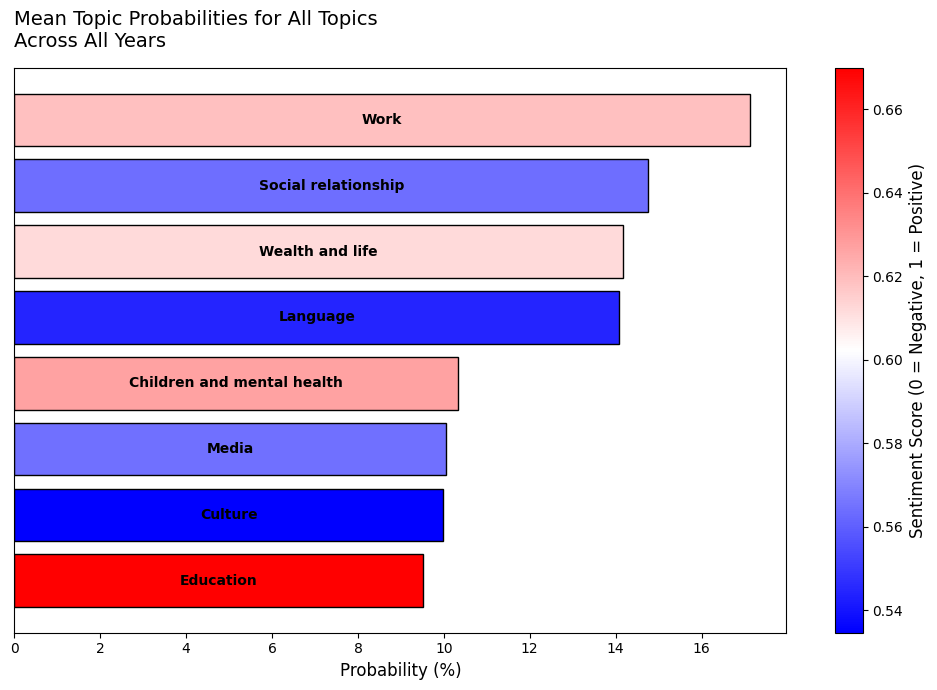

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data: Topic coverage and sentiment values
topic_coverage = [10.34, 9.98, 17.12, 14.17, 10.04, 14.08, 9.51, 14.76]
topic_sentiments = [0.6266053885561871, 0.5346090850204253, 0.6189712244171914,
                    0.6121737425157419, 0.5645840727240153, 0.5445728500161062,
                    0.6698726390047518, 0.563786418893722]
topic_labels = ["Children and mental health", "Culture", "Work", "Wealth and life",
                "Media", "Language", "Education", "Social relationship"]

# Sort topics by coverage in descending order
sorted_indices = np.argsort(topic_coverage)[::-1]
sorted_coverage = [topic_coverage[i] for i in sorted_indices]
sorted_sentiments = [topic_sentiments[i] for i in sorted_indices]
sorted_topics = [topic_labels[i] for i in sorted_indices]

# Create a colormap based on sentiment scores
norm = plt.Normalize(min(sorted_sentiments), max(sorted_sentiments))
colors = cm.bwr(norm(sorted_sentiments))

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))  # Increased figure size for readability
bars = ax.barh(sorted_topics, sorted_coverage, color=colors, edgecolor='black')

# Add topic labels in the center of each bar
for i, bar in enumerate(bars):
    ax.text(
        bar.get_width() / 2,  # Position at half the width
        bar.get_y() + bar.get_height() / 2,  # Center vertically within the bar
        sorted_topics[i],  # Display topic name
        ha='center', va='center', color='black', fontweight='bold', fontsize=10
    )

# Add a colorbar for sentiment
sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm)
sm.set_array(sorted_sentiments)  # Attach the data to the mappable
cbar = plt.colorbar(sm, ax=ax, orientation="vertical")  # Explicitly link the colorbar to the axis
cbar.set_label("Sentiment Score (0 = Negative, 1 = Positive)", fontsize=12)

# Customize plot appearance
ax.set_xlabel("Probability (%)", fontsize=12)
ax.set_title(
    "Mean Topic Probabilities for All Topics\nAcross All Years",
    fontsize=14, loc='left', pad=15
)
ax.invert_yaxis()  # Invert y-axis for descending order
ax.set_yticks([])  # Remove default y-axis labels

# Adjust layout for better appearance
plt.tight_layout()
plt.subplots_adjust(left=0.3)  # Add space on the left for long topic names

# Save and display the plot
output_path = '/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/topic_visualization.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()



#Sentiment analysis

In [ ]:
pip install snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=f9e19ca626d783efb8a59f1665a55c138f09e3ebc8597239dbddc3f715bea8ae
  Stored in directory: /root/.cache/pip/wheels/4a/fc/04/d1937c02b2a445b34754da55f71612a3df648a38d711bd17eb
Successfully built snownlp


In [ ]:
from gensim import models
from snownlp import SnowNLP
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import re
num_topics = 8
passes = 10
random_state = 42

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)
# List to store sentiment scores for each topic
topic_sentiments = []

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

    # Extract words from each topic
    words_probs = topic.split(" + ")
    words = [w.split("*")[1].replace('"', '').strip() for w in words_probs]

    # Calculate sentiment score for each word using SnowNLP
    sentiment_scores = [SnowNLP(word).sentiments for word in words]

    # Calculate the average sentiment for this topic
    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    topic_sentiments.append((idx, avg_sentiment))

# Display the sentiment score for each topic
for topic_id, sentiment in topic_sentiments:
    print(f"Topic {topic_id} Sentiment Score: {sentiment}")

Topic 0: 0.065*"孩子" + 0.027*"吃瓜" + 0.023*"抑郁症" + 0.009*"无" + 0.008*"喜极而泣" + 0.008*"好好" + 0.008*"好" + 0.008*"回" + 0.008*"动画" + 0.007*"中"
Topic 1: 0.014*"穿" + 0.011*"日本" + 0.010*"月" + 0.008*"滑稽" + 0.008*"抄袭" + 0.008*"西方" + 0.007*"岁" + 0.007*"call" + 0.007*"️" + 0.007*"关注"
Topic 2: 0.023*"国外" + 0.023*"中国" + 0.022*"回来" + 0.021*"国内" + 0.017*"留学" + 0.016*"支教" + 0.014*"工作" + 0.013*"生活" + 0.012*"好" + 0.011*"找"
Topic 3: 0.025*"美国" + 0.016*"钱" + 0.013*"海龟" + 0.013*"有钱" + 0.009*"好" + 0.007*"高" + 0.006*"花" + 0.006*"生活" + 0.006*"up" + 0.005*"发展"
Topic 4: 0.020*"视频" + 0.018*"眼睛" + 0.017*"辣" + 0.014*"脱单" + 0.014*"苦" + 0.013*"藏狐" + 0.010*"学生" + 0.009*"公司" + 0.008*"问题" + 0.008*"拍"
Topic 5: 0.036*"笑" + 0.030*"哭" + 0.020*"中文" + 0.020*"英文" + 0.018*"英语" + 0.011*"知道" + 0.010*"学" + 0.008*"专业" + 0.008*"说话" + 0.007*"装"
Topic 6: 0.032*"老师" + 0.012*"妙" + 0.011*"本科" + 0.010*"博士" + 0.010*"硕士" + 0.010*"抄" + 0.009*"医院" + 0.009*"毕业" + 0.008*"北京" + 0.007*"以为"
Topic 7: 0.019*"别人" + 0.017*"好" + 0.013*"不要" + 0.012*"节目" +

#### BERT, sentiment topic

In [ ]:
pip install transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!pip install transformers==4.41.2 --upgrade
!pip install --force-reinstall scipy==1.10.1 numpy==1.24.4 gensim==4.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.1 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [ ]:
from transformers import BertModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118



Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
import transformers
print(transformers.__version__)


4.52.4


In [ ]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import random
import numpy as np

# Update the import statement to correctly import BertForSequenceClassification
from transformers import BertTokenizer
#from transformers import BertForSequenceClassification
from gensim.models.ldamodel import LdaModel
from transformers import BertTokenizer, BertConfig
from transformers import AutoTokenizer

In [ ]:
import torch
import random
import numpy as np

from transformers import BertTokenizer, BertForSequenceClassification
from gensim.models.ldamodel import LdaModel

# Load the BERT Chinese model and tokenizer specifically for sequence classification
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2) # num_labels=2 for binary classification (positive/negative)

# Define a sentiment analysis function that returns the probability of positive sentiment
def predict_sentiment_score(text,random_state=42):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    # The output of BertForSequenceClassification has a 'logits' attribute
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)  # Use softmax to get the probabilities for each class
    positive_prob = probs[0][1].item()  # Get the probability of positive sentiment

    return positive_prob

# Your LDA parameters (assuming these are still needed for subsequent code)
num_topics = 8
passes = 10
random_state = 42

# Assuming you already have corpus and dictionary from previous steps
# If not, ensure corpus and dictionary are defined before this block

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     random_state=random_state,
                     eval_every=None)

topic_sentiments = []

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

    words_probs = topic.split(" + ")
    words = [w.split("*")[1].replace('"', '').strip() for w in words_probs]

    # Use the corrected predict_sentiment_score function
    sentiment_scores = [predict_sentiment_score(word) for word in words]

    avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    topic_sentiments.append((idx, avg_sentiment))

for topic_id, sentiment in topic_sentiments:
    print(f"Topic {topic_id} Sentiment Score: {sentiment:.3f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Topic 0: 0.065*"孩子" + 0.027*"吃瓜" + 0.023*"抑郁症" + 0.009*"无" + 0.008*"好好" + 0.008*"喜极而泣" + 0.008*"好" + 0.008*"回" + 0.008*"动画" + 0.007*"中"
Topic 1: 0.014*"穿" + 0.011*"日本" + 0.010*"月" + 0.008*"滑稽" + 0.008*"抄袭" + 0.008*"西方" + 0.007*"岁" + 0.007*"call" + 0.007*"️" + 0.007*"关注"
Topic 2: 0.023*"国外" + 0.023*"中国" + 0.022*"回来" + 0.021*"国内" + 0.017*"留学" + 0.016*"支教" + 0.015*"工作" + 0.013*"生活" + 0.012*"好" + 0.011*"找"
Topic 3: 0.026*"美国" + 0.016*"钱" + 0.014*"海龟" + 0.013*"有钱" + 0.009*"好" + 0.007*"高" + 0.006*"花" + 0.006*"up" + 0.006*"生活" + 0.005*"发展"
Topic 4: 0.019*"视频" + 0.018*"眼睛" + 0.017*"辣" + 0.014*"脱单" + 0.014*"苦" + 0.013*"藏狐" + 0.010*"学生" + 0.009*"公司" + 0.008*"拍" + 0.008*"问题"
Topic 5: 0.036*"笑" + 0.030*"哭" + 0.020*"中文" + 0.020*"英文" + 0.018*"英语" + 0.011*"知道" + 0.010*"学" + 0.008*"专业" + 0.008*"说话" + 0.007*"装"
Topic 6: 0.032*"老师" + 0.012*"妙" + 0.011*"本科" + 0.010*"博士" + 0.010*"硕士" + 0.010*"抄" + 0.009*"医院" + 0.009*"毕业" + 0.008*"北京" + 0.007*"以为"
Topic 7: 0.019*"别人" + 0.017*"好" + 0.012*"不要" + 0.012*"节目" +

### Bert, bar chart

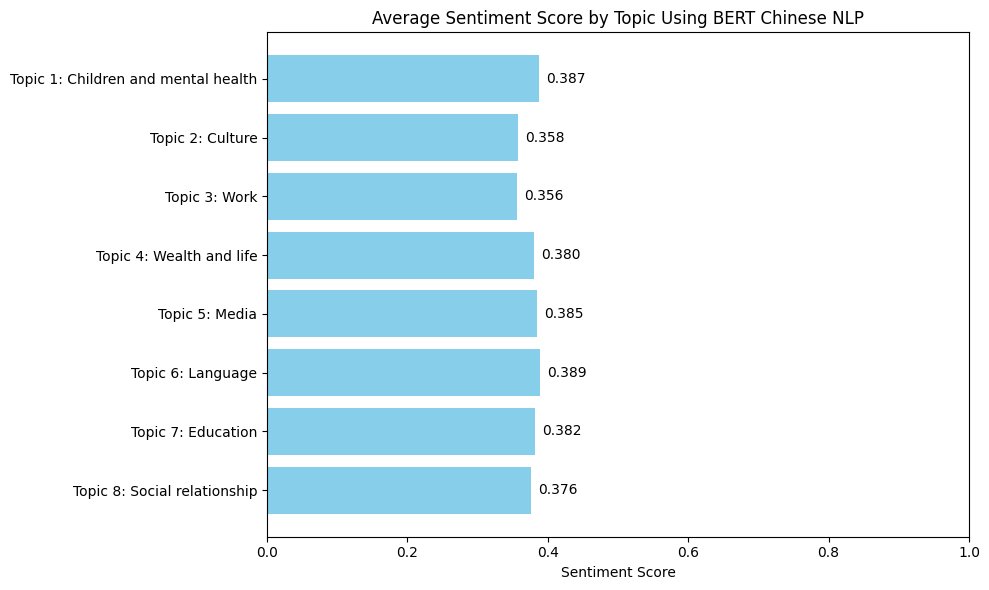

In [ ]:
#Bert, bar chart
import matplotlib.pyplot as plt

# Sentiment scores for each topic (as floats)
sentiment_scores = [0.387, 0.358, 0.356, 0.380, 0.385, 0.389, 0.382, 0.376]

# Custom topic labels
topic_labels = [
    "Topic 1: Children and mental health",
    "Topic 2: Culture",
    "Topic 3: Work",
    "Topic 4: Wealth and life",
    "Topic 5: Media",
    "Topic 6: Language",
    "Topic 7: Education",
    "Topic 8: Social relationship"
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(topic_labels, sentiment_scores, color='skyblue')
plt.xlabel("Sentiment Score")
plt.title("Average Sentiment Score by Topic Using BERT Chinese NLP")
plt.xlim(0, 1)

# Add value labels to the bars
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center')

plt.gca().invert_yaxis()  # Invert to have Topic 1 at the top
plt.tight_layout()
plt.show()


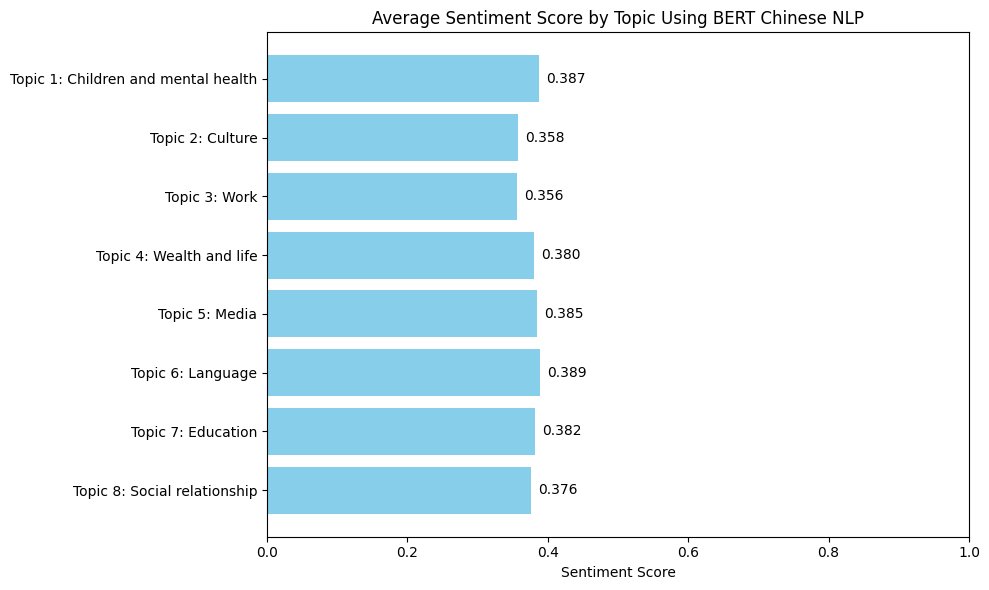

In [ ]:
import matplotlib.pyplot as plt

# Sentiment scores and topic labels
sentiment_scores = [0.387, 0.358, 0.356, 0.380, 0.385, 0.389, 0.382, 0.376]
topic_labels = [
    "Topic 1: Children and mental health",
    "Topic 2: Culture",
    "Topic 3: Work",
    "Topic 4: Wealth and life",
    "Topic 5: Media",
    "Topic 6: Language",
    "Topic 7: Education",
    "Topic 8: Social relationship"
]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(topic_labels, sentiment_scores, color='skyblue')
plt.xlabel("Sentiment Score")
plt.title("Average Sentiment Score by Topic Using BERT Chinese NLP")
plt.xlim(0, 1)

# Add labels
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.3f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()

# Save the figure
plt.savefig("topic_sentiment_scores.png", dpi=300)  # You can change format: .pdf, .svg, etc.

# Show the figure
plt.show()


### BERT and SNOW comparison

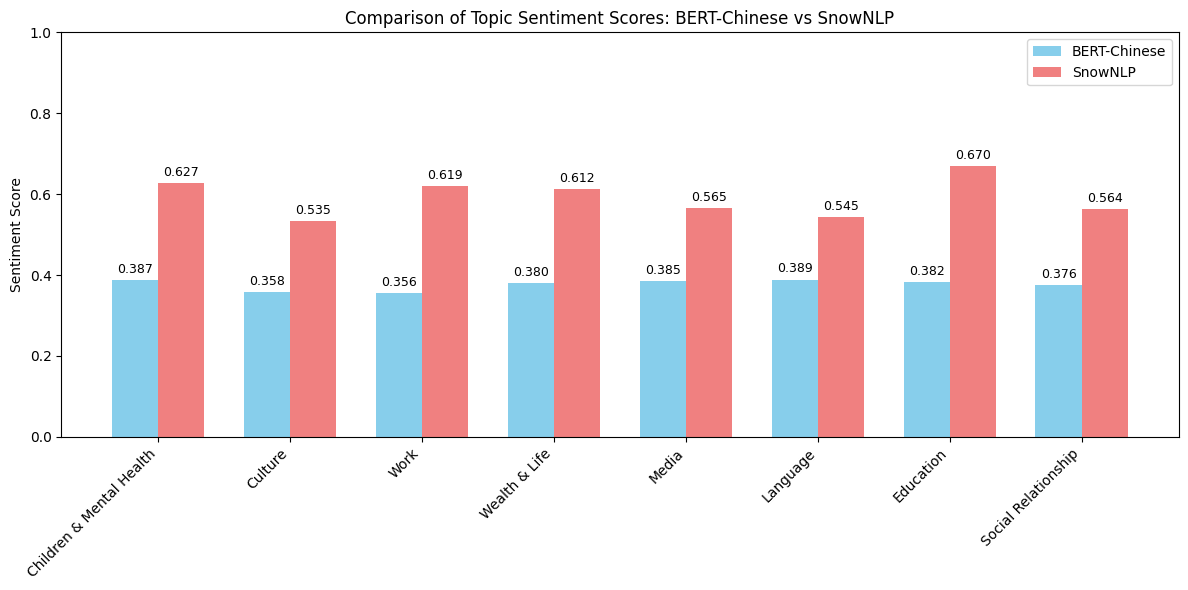

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sentiment scores
snow_sentiments = [
    0.6266053885561871,  # Topic 1
    0.5346090850204253,  # Topic 2
    0.6189712244171914,  # Topic 3
    0.6121737425157419,  # Topic 4
    0.5645840727240153,  # Topic 5
    0.5445728500161062,  # Topic 6
    0.6698726390047518,  # Topic 7
    0.563786418893722    # Topic 8
]

bert_sentiments = [
    0.387, 0.358, 0.356, 0.380, 0.385, 0.389, 0.382, 0.376  # Topic 1 to 8
]

topic_labels = [
    "Children & Mental Health", "Culture", "Work", "Wealth & Life",
    "Media", "Language", "Education", "Social Relationship"
]

x = np.arange(len(topic_labels))  # label locations
width = 0.35  # width of the bars

plt.figure(figsize=(12, 6))
bar1 = plt.bar(x - width/2, bert_sentiments, width, label='BERT-Chinese', color='skyblue')
bar2 = plt.bar(x + width/2, snow_sentiments, width, label='SnowNLP', color='lightcoral')

# Labels and formatting
plt.ylabel('Sentiment Score')
plt.title('Comparison of Topic Sentiment Scores: BERT-Chinese vs SnowNLP')
plt.xticks(x, topic_labels, rotation=45, ha='right')
plt.ylim(0, 1)
plt.legend()

# Add score labels on bars
for bars in [bar1, bar2]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save the figure
plt.savefig("bert_vs_snownlp_sentiment.png", dpi=300)

plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


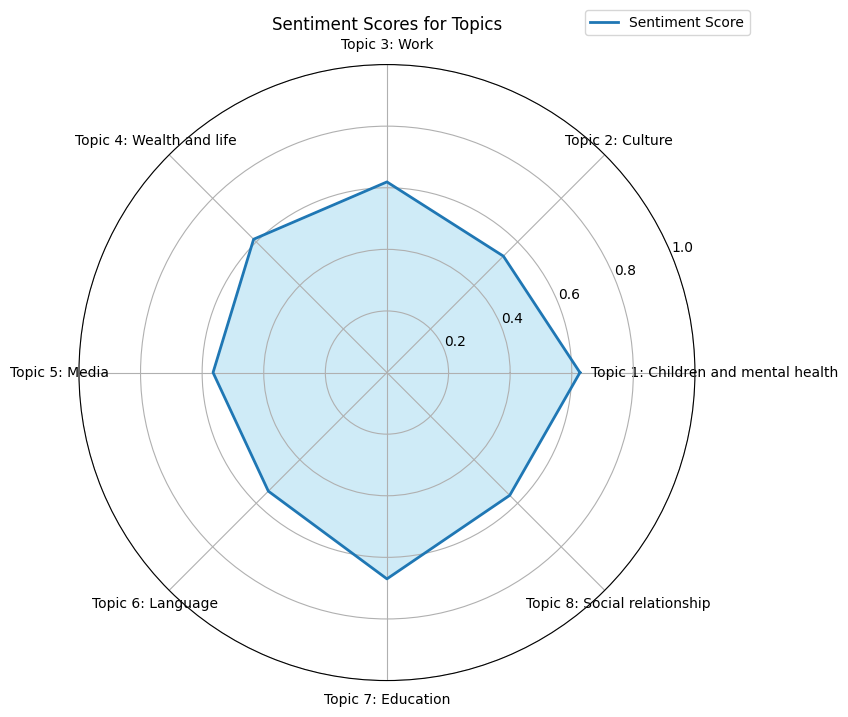

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example sentiment scores for eight topics
topic_sentiments = [
    0.6266053885561871,  # Topic 1: Children and mental health
    0.5346090850204253,  # Topic 2: Culture
    0.6189712244171914,  # Topic 3: Work
    0.6121737425157419,  # Topic 4: Wealth and life
    0.5645840727240153,  # Topic 5: Media
    0.5445728500161062,  # Topic 6: Language
    0.6698726390047518,  # Topic 7: Education
    0.563786418893722    # Topic 8: Social relationship
]

num_topics = len(topic_sentiments)

# Define the labels for each topic
topic_labels = [
    "Topic 1: Children and mental health",
    "Topic 2: Culture",
    "Topic 3: Work",
    "Topic 4: Wealth and life",
    "Topic 5: Media",
    "Topic 6: Language",
    "Topic 7: Education",
    "Topic 8: Social relationship"
]

# Calculate angles for each axis in the plot
angles = np.linspace(0, 2 * np.pi, num_topics, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Close the plot data loop
topic_sentiments += topic_sentiments[:1]  # Append the first value to close the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw the outline of the radar chart
ax.plot(angles, topic_sentiments, linewidth=2, linestyle='solid', label='Sentiment Score')
ax.fill(angles, topic_sentiments, color='skyblue', alpha=0.4)

# Add labels to the chart
ax.set_xticks(angles[:-1])
ax.set_xticklabels(topic_labels)

# Set range for radial axis
ax.set_ylim(0, 1)

# Add a title and legend
plt.title("Sentiment Scores for Topics")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the radar chart
plt.show()

In [ ]:
#sentiment by year
import jieba
import pandas as pd

# Load the stopwords list
def load_stopwords(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        stopwords = set(f.read().splitlines())
    return stopwords

# Path to the stopwords file (replace with the actual path)
stopwords_file = "/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/font/哈工大停用词表.txt"
stopwords = load_stopwords(stopwords_file)

# 1. Extract the required columns and convert the year column to integer type
year_comment_df = combined_all[['Year', 'Comment']]
year_comment_df['Year'] = year_comment_df['Year'].astype(int)

# 2. Group by year and merge the comments into one text per year
merged_comments = year_comment_df.groupby('Year')['Comment'].agg(' '.join).reset_index()

# 3. Define a function to process the comments (segmentation and stopword removal)
def process_comments(comments):
    # Use jieba to segment the comments
    segmented_text = jieba.cut(comments)

    # Remove stopwords and retain meaningful words
    filtered_words = [word for word in segmented_text if word not in stopwords and len(word.strip()) > 0]

    # Recombine the segmented words into a string
    return ' '.join(filtered_words)

# 4. Apply the processing function to the comments for each year
merged_comments['Processed_Comment'] = merged_comments['Comment'].apply(process_comments)

# 5. View the processed data
print(merged_comments[['Year', 'Processed_Comment']].head())


<ipython-input-12-1664277911>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_comment_df['Year'] = year_comment_df['Year'].astype(int)


   Year                                  Processed_Comment
0  2017  练个 剑 道 批评 电视 汗 弹幕 终于 知道 瞧不起 我觉 啥子 要学 别人 强 一面 才...
1  2018  一帮 哈批 人发 哈批 弹幕 别人 整车 做全 喷 地方 佩服 这位 动手 能力 至少 钱 ...
2  2019  说句 实在话 父亲 抓紧时间 培养 孙子辈 我想 问下 儿子 出去 工作 错 结婚 生子 违...
3  2020  艾公 千古 最近 清华 风评 变差 回过 看到 艾公 早就 点到 一层 北大 总冠军 弹幕 ...
4  2021  真正 支教 老师 默默无闻 教书育人 教给 山区 孩子 知识 见识 教 拍 出来 摆 拍来博...


In [ ]:
pip install pandas transformers torch matplotlib

In [ ]:
!pip uninstall transformers -y
!pip uninstall tokenizers -y
!pip uninstall huggingface_hub -y
!pip install transformers==4.52.4

Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
Found existing installation: tokenizers 0.21.1
Uninstalling tokenizers-0.21.1:
  Successfully uninstalled tokenizers-0.21.1
Found existing installation: huggingface-hub 0.32.5
Uninstalling huggingface-hub-0.32.5:
  Successfully uninstalled huggingface-hub-0.32.5
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached huggingface_hub-0.32.5-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached transformers-4.52.4-py3-none-any.whl (10.5 MB)
Using cached huggingface_hub-0.32.5-py3-none-any.whl (512 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT Chinese model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)

# Define the sentiment analysis function
def predict_sentiment(text,random_state=42):
    # Use the tokenizer to encode the text into BERT's input format
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    # Perform prediction in inference mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the output logits from the model and select the label with the highest score
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=-1).item()

    # Return the sentiment label based on the prediction result
    return "Positive" if prediction == 1 else "Negative"


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd

# Perform sentiment analysis on the merged comments for each year and store the results in the 'Sentiment' column
merged_comments['Sentiment'] = merged_comments['Processed_Comment'].apply(predict_sentiment)

# View a portion of the results
print(merged_comments[['Year', 'Processed_Comment', 'Sentiment']].head())


   Year                                  Processed_Comment Sentiment
0  2017  练个 剑 道 批评 电视 汗 弹幕 终于 知道 瞧不起 我觉 啥子 要学 别人 强 一面 才...  Negative
1  2018  一帮 哈批 人发 哈批 弹幕 别人 整车 做全 喷 地方 佩服 这位 动手 能力 至少 钱 ...  Positive
2  2019  说句 实在话 父亲 抓紧时间 培养 孙子辈 我想 问下 儿子 出去 工作 错 结婚 生子 违...  Positive
3  2020  艾公 千古 最近 清华 风评 变差 回过 看到 艾公 早就 点到 一层 北大 总冠军 弹幕 ...  Positive
4  2021  真正 支教 老师 默默无闻 教书育人 教给 山区 孩子 知识 见识 教 拍 出来 摆 拍来博...  Negative


In [ ]:
import torch
import random
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT Chinese model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)

# Define a sentiment analysis function that returns the probability of positive sentiment
def predict_sentiment_score(text,random_state=42):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)  # Use softmax to get the probabilities for each class
    positive_prob = probs[0][1].item()  # Get the probability of positive sentiment

    return positive_prob


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import pandas as pd

# Use the sentiment analysis function to generate positive sentiment scores for each year's comments
merged_comments['Sentiment_Score'] = merged_comments['Processed_Comment'].apply(predict_sentiment_score)

# Calculate the average sentiment score by year
yearly_sentiment_score = merged_comments.groupby('Year')['Sentiment_Score'].mean().reset_index()

# View the results
print(yearly_sentiment_score)


   Year  Sentiment_Score
0  2017         0.453310
1  2018         0.407519
2  2019         0.350137
3  2020         0.418212
4  2021         0.291627
5  2022         0.373588
6  2023         0.411377
7  2024         0.399745


In [ ]:
# Add a Negative_Score column to the yearly_sentiment_score DataFrame
yearly_sentiment_score['Negative_Score'] = 1 - yearly_sentiment_score['Sentiment_Score']

# View the results
print(yearly_sentiment_score)


   Year  Sentiment_Score  Negative_Score
0  2017         0.453310        0.546690
1  2018         0.407519        0.592481
2  2019         0.350137        0.649863
3  2020         0.418212        0.581788
4  2021         0.291627        0.708373
5  2022         0.373588        0.626412
6  2023         0.411377        0.588623
7  2024         0.399745        0.600255


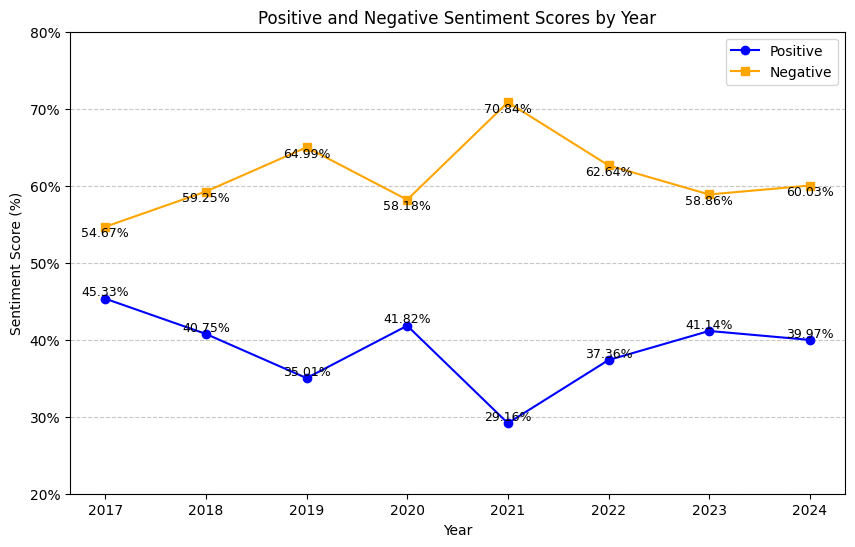

In [ ]:
import matplotlib.pyplot as plt

# Plot the chart
plt.figure(figsize=(10, 6))

# Plot the positive sentiment score line
plt.plot(yearly_sentiment_score['Year'], yearly_sentiment_score['Sentiment_Score'],
         marker='o', label='Positive', color='blue')

# Plot the negative sentiment score line
plt.plot(yearly_sentiment_score['Year'], yearly_sentiment_score['Negative_Score'],
         marker='s', label='Negative', color='orange')

# Add labels to each point
for i in range(len(yearly_sentiment_score)):
    plt.text(yearly_sentiment_score['Year'][i], yearly_sentiment_score['Sentiment_Score'][i],
             f"{yearly_sentiment_score['Sentiment_Score'][i]:.2%}",
             ha='center', va='bottom', fontsize=9)
    plt.text(yearly_sentiment_score['Year'][i], yearly_sentiment_score['Negative_Score'][i],
             f"{yearly_sentiment_score['Negative_Score'][i]:.2%}",
             ha='center', va='top', fontsize=9)

# Set the y-axis range and percentage scale labels
plt.ylim(0.2, 0.8)  # Set the y-axis range from 20% to 80%

# Format the y-axis labels as percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))

# Set title and labels
plt.title('Positive and Negative Sentiment Scores by Year')
plt.xlabel('Year')
plt.ylabel('Sentiment Score (%)')

# Add a legend
plt.legend()

# Display gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.show()


### Snow by topic and year

In [ ]:
!pip install snownlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for snownlp: filename=snownlp-0.12.3-py3-none-any.whl size=37760946 sha256=3c20a15290af058aefb8bcb2db6a00b5f725efc1b1c7275a4bd688f29a2ce669
  Stored in directory: /root/.cache/pip/wheels/4a/fc/04/d1937c02b2a445b34754da55f71612a3df648a38d711bd17eb
Successfully built snownlp


In [ ]:
merged_comments

Year                                            Comment  \
0  2017  练个剑道而已，就开始批评人家[小电视_汗] 看了弹幕终于知道什么叫瞧不起自己了 我觉的没啥子...   
1  2018  一帮哈批人发的哈批弹幕，别人就算整车做全了，你们还是能有喷的地方 首先得说，确实佩服这位的动...   
2  2019  说句实在话，他父亲应该抓紧时间培养孙子辈，我想问下，儿子除了不出去工作，别的有做错什么吗?结...   
3  2020  艾公千古，最近清华风评变差，回过来看到艾公早就点到这一层了 北大总冠军！ 弹幕评论居然还有骂...   
4  2021  一个真正支教的老师是默默无闻教书育人，真的教给山区孩子知识，见识的，而不是教什么，做什么都要...   
5  2022  学而优则仕 考编当然难啦毕竟考了研也还是要考编[笑哭] 农村广阔天地大有作为 人 才 济 济...   
6  2023  计算机硕士做运营？以前是做运营账号的？玛雅 招人是HR面试人吗？不是HR请对应部门的主管来面...   
7  2024  没背景进什么体制内。老老实实做技术吧。[笑哭] 要考的一律不看，都tm读博了，就是不想跟别人...   

                                   Processed_Comment Sentiment  \
0  练个 剑 道 批评 电视 汗 弹幕 终于 知道 瞧不起 我觉 啥子 要学 别人 强 一面 才...  Negative   
1  一帮 哈批 人发 哈批 弹幕 别人 整车 做全 喷 地方 佩服 这位 动手 能力 至少 钱 ...  Positive   
2  说句 实在话 父亲 抓紧时间 培养 孙子辈 我想 问下 儿子 出去 工作 错 结婚 生子 违...  Positive   
3  艾公 千古 最近 清华 风评 变差 回过 看到 艾公 早就 点到 一层 北大 总冠军 弹幕 ...  Positive   
4  真正 支教 老师 默默无闻 教书育人 教给 山区 孩子 知识 见识 教 拍 出来 摆 拍来博...  Negative   
5  学而优则仕 考编 当然 难 毕竟 考了 研也 考编 笑 哭 农村 广阔天地 大有作为 济 济...  Negative   
6  计算机 硕士 运营 以前 运营 账号 玛雅 招人 HR 面试 HR 请 对应 部门 主管 面...  Negative   
7  背景 进 体制 内 老老实实 技术 笑 哭 要考 一律 不看 tm 读博 不想 别人 写题 ...  Positive   

   Sentiment_Score  SnowSentiment  
0         0.453310            1.0  
1         0.407519            1.0  
2         0.350137            1.0  
3         0.418212            1.0  
4         0.291627            1.0  
5         0.373588            1.0  
6         0.411377            1.0  
7         0.399745            1.0

In [ ]:
from snownlp import SnowNLP
import pandas as pd
import matplotlib.pyplot as plt

# Apply SnowNLP to compute sentiment score for each processed comment
merged_comments['SnowSentiment'] = merged_comments['Comment'].apply(lambda x: SnowNLP(x).sentiments)
# Group by year and compute the average sentiment score
snow_sentiment_by_year = merged_comments.groupby('Year')['SnowSentiment'].mean().reset_index()
print(snow_sentiment_by_year)


   Year  SnowSentiment
0  2017            1.0
1  2018            1.0
2  2019            1.0
3  2020            1.0
4  2021            1.0
5  2022            1.0
6  2023            1.0
7  2024            1.0


In [ ]:
print(merged_comments['Comment'].head(10))


0    练个剑道而已，就开始批评人家[小电视_汗] 看了弹幕终于知道什么叫瞧不起自己了 我觉的没啥子...
1    一帮哈批人发的哈批弹幕，别人就算整车做全了，你们还是能有喷的地方 首先得说，确实佩服这位的动...
2    说句实在话，他父亲应该抓紧时间培养孙子辈，我想问下，儿子除了不出去工作，别的有做错什么吗?结...
3    艾公千古，最近清华风评变差，回过来看到艾公早就点到这一层了 北大总冠军！ 弹幕评论居然还有骂...
4    一个真正支教的老师是默默无闻教书育人，真的教给山区孩子知识，见识的，而不是教什么，做什么都要...
5    学而优则仕 考编当然难啦毕竟考了研也还是要考编[笑哭] 农村广阔天地大有作为 人 才 济 济...
6    计算机硕士做运营？以前是做运营账号的？玛雅 招人是HR面试人吗？不是HR请对应部门的主管来面...
7    没背景进什么体制内。老老实实做技术吧。[笑哭] 要考的一律不看，都tm读博了，就是不想跟别人...
Name: Comment, dtype: object


In [ ]:
# Step 1: Load and Preprocess Data
import pandas as pd
import jieba
from transformers import pipeline, AutoTokenizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
import matplotlib.pyplot as plt

# Load data
data_path = '/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/combined_all_new.csv'  # Update this with your actual file path
df = pd.read_csv(data_path)
df = df.dropna(subset=['Comment', 'Year'])  # Drop rows with missing values in 'Comment' or 'Year'

# Step 2: LDA Topic Modeling
# Tokenize comments
stopwords_file = "/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/font/哈工大停用词表.txt"
with open(stopwords_file, 'r', encoding='utf-8') as f:
    stopwords = set(f.read().splitlines())

df['tokens'] = df['Comment'].apply(lambda x: [word for word in jieba.cut(x) if word not in stopwords])

# Create dictionary and corpus for LDA
dictionary = Dictionary(df['tokens'])
dictionary.filter_extremes(no_below=0.001, no_above=0.90, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Train LDA model
num_topics = 8
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Assign each comment to a topic
def get_topic(comment_tokens):
    bow = dictionary.doc2bow(comment_tokens)
    topic_probs = lda_model.get_document_topics(bow)
    top_topic = max(topic_probs, key=lambda x: x[1])[0]
    return top_topic

df['Topic'] = df['tokens'].apply(get_topic)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


      Year  Topic                                            Comment  \
0   2017.0      0  纠结刀剑分不分的人是有病吧…… 有些人真是狭隘不了解就瞎逼逼。这种人不仅很无知其次他的人生一...   
1   2017.0      1  路过支持一下 有人觉得这些什么跆拳道，剑道等等都不行，一枪解决\n我有个招，移民上欧洲，练习...   
2   2017.0      2  日本人中国文化白学了，刀剑都分不清。真是沐猴而冠啊。╮(￣▽￣)╭ 现代剑道体育虽强盛与日本...   
3   2017.0      3  “I wish I have～american's～girl friend.” 不要怪人家学...   
4   2017.0      4  我觉的没啥子嘛，就是要学别人强的一面，才能打倒别人和了解别人嘛！ 剑:百器之首，君子相宜。\...   
..     ...    ...                                                ...   
59  2024.0      3  无所调位   你不关心我，我懒得关心你   不过几十年  武魂午后无放贷 美国：共38所入围...   
60  2024.0      4  太感动了，这么多高端人士抢着来服务我，深深的自豪[妙啊][妙啊][妙啊] 希望有钱的过得好，...   
61  2024.0      5  哎，直接面试，真的羡慕了 孩儿他爸妈操碎了心 非党员也能考定向选调？ 用不着酸，留学生选调和...   
62  2024.0      6  挺好的，关我屁事，爱咋咋 恭喜[星星眼] 习惯就好 再卡个qs50，直接利好英区澳区 名校优...   
63  2024.0      7  唉，怎么办呢，越来越难了 太好啦！ 度个金皮就是香 想必公子小姐们应该都是MIT、斯坦福、加...   

    Sentiment_Score  
0          0.640373  
1          0.603973  
2          0.626921  
3          0.555088  
4          0.639425  
.. 

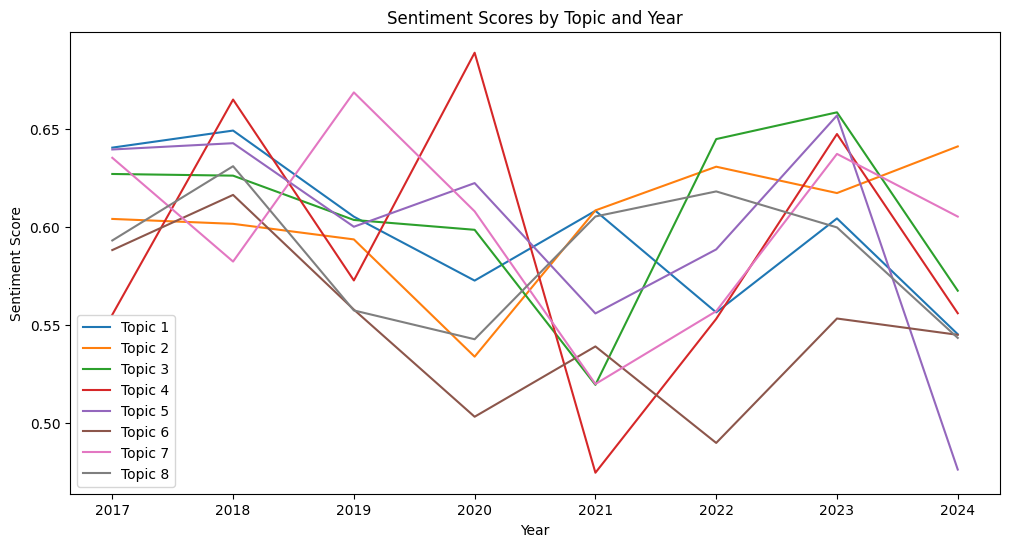

In [ ]:
# Step 3: Sentiment Analysis with bert-base-chinese
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=2)

# Define a function to calculate sentiment score
def calculate_sentiment_score(text,random_state=42):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1)
    positive_prob = probs[0][1].item()  # Probability of positive sentiment
    return positive_prob

# Step 4: Aggregate comments by year and topic
aggregated_data = df.groupby(['Year', 'Topic'])['Comment'].apply(lambda x: ' '.join(x)).reset_index()

# Calculate sentiment scores for each year-topic group
aggregated_data['Sentiment_Score'] = aggregated_data['Comment'].apply(calculate_sentiment_score)

# Step 5: Analyze sentiment scores
# Display the results
print(aggregated_data)

# Optional: Visualize sentiment scores
plt.figure(figsize=(12, 6))
for topic in range(num_topics):
    topic_data = aggregated_data[aggregated_data['Topic'] == topic]
    plt.plot(topic_data['Year'], topic_data['Sentiment_Score'], label=f'Topic {topic+1}')
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores by Topic and Year')
plt.legend()
plt.show()

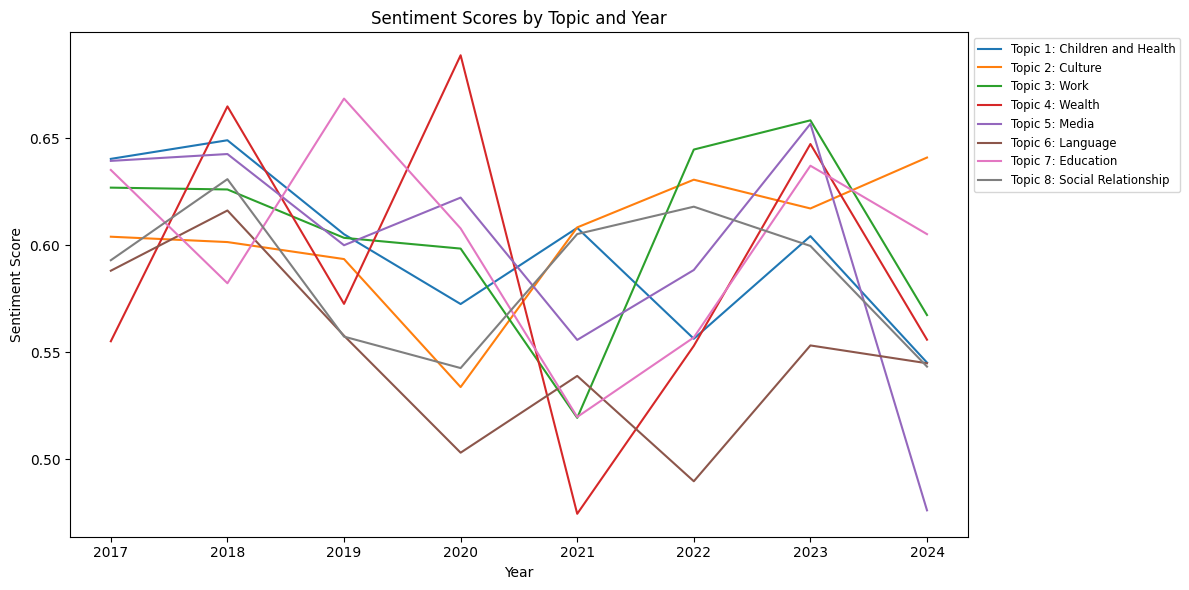

In [ ]:
# Define topic names
topic_names = {
    0: 'Topic 1: Children and Health',
    1: 'Topic 2: Culture',
    2: 'Topic 3: Work',
    3: 'Topic 4: Wealth',
    4: 'Topic 5: Media',
    5: 'Topic 6: Language',
    6: 'Topic 7: Education',
    7: 'Topic 8: Social Relationship'
}

# Plot sentiment scores by topic and year
plt.figure(figsize=(12, 6))
for topic in range(num_topics):
    topic_data = aggregated_data[aggregated_data['Topic'] == topic]
    plt.plot(topic_data['Year'], topic_data['Sentiment_Score'], label=topic_names[topic])

plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores by Topic and Year')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')  # Adjust legend position and size
plt.tight_layout()
plt.show()

#Dependency parsing

In [ ]:
import spacy
from spacy import displacy
import pandas as pd

In [ ]:
!python -m spacy download zh_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 21.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('zh_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
text = '看了弹幕终于知道什么叫瞧不起自己了	'
nlp = spacy.load('zh_core_web_sm')
doc = nlp(text)
# We can see the dependency tree
displacy.render(doc, style="dep")

In [ ]:
df = combined_all #Reduce the size of the sample if you want to save time
df["processed"] = df['Comment'].apply(lambda x: nlp(x))
def extract_subject_verb_pairs(sent):
    # Select subjects (主语)
    subjects = [w for w in sent if w.dep_ == "nsubj"]
    # Select verbs (谓语)
    verbs = [w for w in sent if w.dep_ == "ROOT" or w.dep_ == "VERB"]

    # Create pairs of subjects with verbs
    pairs = []
    for subj in subjects:
        for verb in verbs:
            pairs.append((subj.text, verb.text))  # Use .text to get the actual word
    return pairs

# Extract subject-verb pairs
df["subj-verb-pairs"] = df["processed"].apply(lambda x: extract_subject_verb_pairs(x))

# Display the DataFrame with subject-verb pairs
print(df[['Comment', 'subj-verb-pairs']])

                                                  Comment  \
0                                   练个剑道而已，就开始批评人家[小电视_汗]   
1                                       看了弹幕终于知道什么叫瞧不起自己了   
2                        我觉的没啥子嘛，就是要学别人强的一面，才能打倒别人和了解别人嘛！   
3                       日本人中国文化白学了，刀剑都分不清。真是沐猴而冠啊。╮(￣▽￣)╭   
4       在中国，剑有剑术，刀有刀法，各种细分，还有个统称叫武术，拿着把刀练剑术……貌似在中国顶多给个...   
...                                                   ...   
158733           马云以前是大学英语老师，在他面前装什么装啊，好好说话比什么都好，[笑哭][笑哭]   
158734                               你在外面你敢英文夹中文吗？来国内装什么？   
158735                               初中英语厂狗都听得懂，你这b装的太低级了   
158736                               王自如正是这类崇洋媚外的舔狗中的典型代表   
158737                                      为啥不是“最big的挑战”   

                                          subj-verb-pairs  
0                                                      []  
1                                      [(弹幕, 看), (什么, 看)]  
2                               [(我, ！), (觉, ！), (别人, ！)]  
3       [(文化, 分), (文化, 。), 

In [ ]:
import pandas as pd

# Step 1: Flatten the list of subject-verb pairs from the 'subj-verb-pairs' column
all_subj_verb_pairs = [pair for sublist in df['subj-verb-pairs'] for pair in sublist]

# Step 2: Convert the list of pairs to a DataFrame and count the occurrences
subj_verb_df = pd.DataFrame(all_subj_verb_pairs, columns=['Subject', 'Verb'])
subj_verb_counts = subj_verb_df.groupby(['Subject', 'Verb']).size().reset_index(name='Count')

# Step 3: Sort the pairs by their count in descending order to see the most common pairs
most_common_pairs = subj_verb_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)

# Optional: Filter or display only the top N for clarity
most_common_pairs.head(16)  # Adjust N to your preference

Subject Verb  Count
0        我   觉得   1445
1        你    ？   1430
2        我    ？   1073
3        我    说   1063
4        你    说    776
5        我    想    741
6        我    有    738
7        我    。    564
8        我    看    553
9        我   知道    535
10       你    有    514
11       人    ？    500
12       人    有    396
13       人    说    372
14       你   觉得    364
15       你    。    341

In [ ]:
#gender=male
most_common_pairs.loc[most_common_pairs['Subject']=="他"]

Subject Verb  Count
18          他    说    284
20          他    ？    279
31          他    有    192
35          他   觉得    184
59          他   知道    135
...       ...  ...    ...
86614       他    住      1
86615       他  低情商      1
86616       他   传授      1
86617       他   伏吟      1
86618       他   仿造      1

[1265 rows x 3 columns]

In [ ]:
#gender=female
most_common_pairs.loc[most_common_pairs['Subject']=="她"]

Subject Verb  Count
30           她   觉得    202
39           她    说    171
54           她    ？    152
83           她    有    100
91           她    。     89
...        ...  ...    ...
111563       她   交换      1
111564       她   书后      1
111565       她   习惯      1
111566       她    久      1
111567       她    举      1

[841 rows x 3 columns]

In [ ]:
male_nouns = [
    "他","男的","他们","男人", "男孩", "父亲", "儿子", "兄弟", "丈夫", "叔叔", "舅舅", "侄子",
    "男留学生", "男演员", "男神","他们的","警察", "他", "男人们", "男孩们",
    "父亲们","儿子们", "兄弟们", "丈夫们", "叔叔们", "舅舅们", "侄子们"
]

female_nouns = [
    "她","女的","她们","女人","女孩", "母亲", "女儿", "姐妹", "妻子", "阿姨", "姑姑", "侄女",
    "女士", "夫人", "女服务员", "女演员", "女神","女留学生", "她", "女人们", "女孩们","她们的",
    "母亲们", "女儿们", "姐妹们", "妻子们", "阿姨们", "姑姑们", "侄女们"
]


In [ ]:
#replace them using <MALE> or <FEMALE>
subj_verb_counts_gender = subj_verb_counts.copy(deep=True)
subj_verb_counts_gender['Subject'] = subj_verb_counts_gender['Subject'].apply(lambda x: "<MALE>" if x in male_nouns else x)
subj_verb_counts_gender['Subject'] = subj_verb_counts_gender['Subject'].apply(lambda x: "<FEMALE>" if x in female_nouns else x)

In [ ]:
subj_verb_counts_gender.loc[subj_verb_counts_gender['Subject']=="<MALE>"]

Subject Verb  Count
5352   <MALE>   只有      1
5353   <MALE>    大      1
5354   <MALE>    想      1
5355   <MALE>   攀比      1
5356   <MALE>    有      1
...       ...  ...    ...
98153  <MALE>   觉得      1
98154  <MALE>   试试      1
98155  <MALE>   这就      1
98156  <MALE>   连发      1
98157  <MALE>    ？      1

[2605 rows x 3 columns]

In [ ]:
subj_verb_counts_gender.loc[subj_verb_counts_gender['Subject']=="<FEMALE>"]

Subject    Verb  Count
21597   <FEMALE>       人      1
21598   <FEMALE>       哭      1
21599   <FEMALE>       扒      1
21600   <FEMALE>       有      1
40584   <FEMALE>  [doge]      1
...          ...     ...    ...
109688  <FEMALE>      糖水      1
109689  <FEMALE>      说出      1
109690  <FEMALE>      音娘      2
109691  <FEMALE>       ！      2
109692  <FEMALE>       看      1

[1782 rows x 3 columns]

In [ ]:
#We need to aggregate because we created new duplicates
subj_verb_counts_gender = subj_verb_counts_gender.groupby(['Subject', 'Verb'])['Count'].sum().reset_index()
subj_verb_counts_gender.sort_values(by='Count', ascending=False)

Subject Verb  Count
60202        我   觉得   1445
21930        你    ？   1430
60729        我    ？   1073
60278        我    说   1063
21608        你    说    776
...        ...  ...    ...
43333       学业   没有      1
43332       学业   明显      1
43331       学业   承受      1
43330       学业    想      1
111897      🤣👉    还      1

[111898 rows x 3 columns]

In [ ]:
most_common_pairs.loc[(most_common_pairs['Subject'] == "海归")].head(20)


Subject Verb  Count
487       海归    有     26
494       海归    ？     25
836       海归    说     18
1003      海归    。     16
1289      海归   觉得     13
1996      海归    好      9
2008      海归   感觉      9
2678      海归   回来      8
3167      海归    人      7
3170      海归    没      7
4079      海归    想      6
5392      海归   还有      5
5393      海归   证明      5
5396      海归   知道      5
5398      海归   没有      5
5400      海归   怎样      5
5402      海归    上      5
6275      海归   (海      4
6276      海归    ]      4
6277      海归   了解      4

In [ ]:
most_common_pairs.loc[most_common_pairs['Subject']=="归国"]

Subject Verb  Count
91056      归国   还有      1
91057      归国   理想      1
91058      归国    想      1
91059      归国   回来      1
91060      归国   值得      1
91061      归国   乐意      1
91062      归国    。      1

In [ ]:
def find_sentences_with_keyword(keyword, document):
    # Filter sentences that contain the keyword
    sentences_with_keyword = document[document.str.contains(keyword, case=False, na=False)]
    return sentences_with_keyword

# Example usage:
sentences_with_haigui = find_sentences_with_keyword("海归", df['Comment'])
print(sentences_with_haigui)


273       最近在了解张绍刚这个人，看到这位海归也是蛮心疼的，但更可悲的是几个视频下来我的黑名单里多了几...
903       我对张绍刚感觉就是:三观很正，但是对待“国内求职者”和“海归”，有两种截然不同的心态。\n\...
1111      有没有人觉得这里的评论非黑即白？？？？这个女boss是个不好的人，节目垃圾主持人不专业，我知...
1126      张绍刚这个人怎么说呢，他对海归留学生有一种天然的敌意和仇视，但同时也对穷苦家庭出身的应聘者有...
1177      站哨肛是一贯的仇视海归的应聘者，这已经不是第一次了，另一个应聘者刘莉莉也遭遇到站哨肛无理的讽...
                                ...                        
158644                      海归等于高素质人才这种观念早就不存在了吧，顶多说明你家不是太穷
158697                                           这都什么年代了还海归
158716                               这女的确实很装，说到海归的时候还甩了一下头发
158719                                 我以为这标题是一个海归女对着马云脸上放屁
158729                                               海归确实nb
Name: Comment, Length: 590, dtype: object


In [ ]:
immigrant_nouns=['海归','海龟','海归学子']
worker_nouns=['求职者']#,'男嘉宾','求职人','嘉宾','仁兄','郭杰','小哥','小伙子',]
abroad_nouns=['留学生']

In [ ]:
subj_verb_counts_migrant = subj_verb_counts.copy(deep=True)
subj_verb_counts_migrant['Subject'] = subj_verb_counts_migrant['Subject'].apply(lambda x: "<migrant>" if x in immigrant_nouns else x)
subj_verb_counts_migrant['Subject'] = subj_verb_counts_migrant['Subject'].apply(lambda x: "<migrant worker>" if x in worker_nouns else x)
subj_verb_counts_migrant['Subject'] = subj_verb_counts_migrant['Subject'].apply(lambda x: "<study abroad>" if x in abroad_nouns else x)

In [ ]:
import numpy as np

import numpy as np

def calculate_pmi(subject, verb, dataframe):
    try:
        total_count = dataframe['Count'].sum()

        # Sum of "Counts" for all rows containing the specified subject
        subject_sum = dataframe[dataframe['Subject'] == subject]['Count'].sum()

        # Sum of "Counts" for all rows containing the specified verb
        verb_sum = dataframe[dataframe['Verb'] == verb]['Count'].sum()

        # Check if subject or verb is not in the dataset
        if subject_sum == 0 or verb_sum == 0:
            raise ValueError(f"Either subject '{subject}' or verb '{verb}' does not exist in the dataset.")

        # Number of "Counts" for the row that corresponds to the "Verb" and "Subject"
        specific_pair_count = dataframe[(dataframe['Subject'] == subject) & (dataframe['Verb'] == verb)]['Count'].sum()

        # Check if the specific subject-verb pair never occurs together
        if specific_pair_count == 0:
            raise ValueError(f"The specific subject-verb pair ('{subject}', '{verb}') never occurs together in the dataset.")

        # Calculate probabilities
        p_x_y = specific_pair_count / total_count
        p_x = subject_sum / total_count
        p_y = verb_sum / total_count

        # Calculate PMI
        pmi = np.log(p_x_y / (p_x * p_y))
        return pmi

    except ValueError as e:
        # Return the error message instead of raising an exception, or handle it as desired
        return str(e)

In [ ]:
# Step 1: Identify verbs that appear at least 50 times
verbs_at_least_50 = subj_verb_counts_migrant.groupby('Verb')['Count'].sum()
verbs_at_least_50 = verbs_at_least_50[verbs_at_least_50 >= 50].index.tolist()

# Initialize lists to store PMI results
migrant_pmi_list = []
seeker_pmi_list = []
student_pmi_list = []
# Step 2 & 3: Calculate the PMI for "<MALE>" and "<FEMALE>" with these verbs
for verb in verbs_at_least_50:
    migrant_pmi = calculate_pmi("<migrant>", verb, subj_verb_counts_migrant)
    seeker_pmi = calculate_pmi("<migrant worker>", verb, subj_verb_counts_migrant)
    student_pmi = calculate_pmi("<study abroad>", verb, subj_verb_counts_migrant)

    # Append the results to the lists
    migrant_pmi_list.append({'Verb': verb, 'PMI': migrant_pmi})
    seeker_pmi_list.append({'Verb': verb, 'PMI': seeker_pmi})
    student_pmi_list.append({'Verb': verb, 'PMI': student_pmi})

migrant_df = pd.DataFrame(migrant_pmi_list)
seeker_df = pd.DataFrame(seeker_pmi_list)
student_df = pd.DataFrame(student_pmi_list)

# Optionally, you might want to handle or filter out potential errors or 'NaN' values from the PMI calculation
migrant_df = migrant_df.dropna()  # This removes rows where PMI couldn't be calculated
seeker_df = seeker_df.dropna()
student_df = student_df.dropna()

In [ ]:
# Convert the 'PMI' column to numeric, coercing errors to NaN, then drop NaN values for migrant_df
migrant_df['PMI'] = pd.to_numeric(migrant_df['PMI'], errors='coerce')
migrant_df = migrant_df.dropna(subset=['PMI'])

# Repeat the process for seeker_df
seeker_df['PMI'] = pd.to_numeric(seeker_df['PMI'], errors='coerce')
seeker_df = seeker_df.dropna(subset=['PMI'])
# Repeat the process for student_df
student_df['PMI'] = pd.to_numeric(student_df['PMI'], errors='coerce')
student_df = student_df.dropna(subset=['PMI'])

In [ ]:
migrant_df.sort_values(by=['PMI'], ascending=False).head(20)

Verb       PMI
378    挂  2.875760
190   吃香  2.850007
445    正  2.561266
320   怎么  2.561266
245   大学  2.484893
465   海归  2.416685
86    人才  2.332425
670    重  2.309952
291   带有  2.289585
72    之前  2.154039
615   说明  2.099231
481   猜测  2.079428
200   听到  1.997879
280    就  1.985902
500    的  1.968203
65     为  1.916909
198    吧  1.836867
607   证明  1.831752
227   回来  1.798069
268   学生  1.784420

In [ ]:
seeker_df.sort_values(by=['PMI'], ascending=False).head(20)

Verb       PMI
220    嘲讽  4.006540
9      01  3.775428
14     DS  3.775428
445     正  3.775428
645    过分  3.744176
152    助理  3.699055
487    生成  3.441226
481    猜测  3.293590
351    懂得  3.255124
405    攻击  3.200064
333    情况  3.156389
552    羡慕  3.139439
653    进行  3.131071
291    带有  3.098281
414    新迷  3.098281
84     亮相  3.098281
368    担当  3.051028
399    播出  3.005908
153    包括  2.991309
491  由此可见  2.962736

#Neighbor words

In [ ]:
# Tokenize and filter each comment
filtered_documents = []
for comment in df['Comment'].astype(str):
    # Use jieba to tokenize
    tokens = jieba.cut(comment)
    # Remove stop words and empty tokens, and add to the list
    filtered_tokens = [word for word in tokens if word not in stopwords and len(word.strip()) > 0]
    filtered_documents.append(filtered_tokens)

# filtered_documents now contains a list of lists with tokenized and filtered words for each comment
print(filtered_documents)

[['练个', '剑', '道', '批评', '电视', '汗'], ['弹幕', '终于', '知道', '瞧不起'], ['我觉', '啥子', '要学', '别人', '强', '一面', '才能', '打倒', '别人', '了解', '别人'], ['日本', '中国', '文化', '白学', '刀剑', '分不清', '真是', '沐猴而冠', '╮', '￣', '▽', '￣', '╭'], ['中国', '剑', '剑术', '刀', '刀法', '细分', '统称', '武术', '刀练', '剑术', '貌似', '中国', '顶多', '刀术', '称谓'], ['现代', '剑道', '体育', '强盛', '日本', '剑', '道', '本身', '起源于', '中国', '春秋时期', '好', '复兴', '剑', '道', '传播', '日本', '文化', '清', '弹幕', '学习', '再来侃'], ['剑', '百器', '之首', '君子', '相宜', '刀', '沙场', '屠手', '杀人', '利器'], ['I', 'wish', 'I', 'have', 'american', 's', 'girl', 'friend'], ['纠结', '刀剑', '分不分', '病'], ['诸君', '请容', '一句', '认为', '真正', '扎眼', '剑', '道', '前面', '隐形', '日本', '两字', '似乎', '一种', '默认', '日本', '剑道', '在世界上', '影响', '挺大', '抵制', '大家', '知道', '原因', '抵制', '请', '不要', '总是', '国家', '卖国', '问题', '学习', '剑', '道', '多数', '图个', '防身', '技能', '精神', '升华', '成', '严重', '些', '热爱祖国', '没错', '请', '不要', '成为', '愤青'], ['路过', '支持'], ['剑道', '源于', '中国', '玩', '日本', '真他妈', '文盲'], ['不要', '怪', '学剑道', '传统武术', '海外', '混得', '好', '咏春', '怪', '不争气', '我想学', '八

In [ ]:
!pip install nltk
import nltk
from nltk import bigrams
from collections import Counter # Assuming Counter is also needed

# Generate bigrams from all tokenized comments
all_bigrams = [pair for comment in filtered_documents for pair in bigrams(comment)]

# Count frequency of each bigram
bigram_counts = Counter(all_bigrams)

In [ ]:
# Generate bigrams from all tokenized comments
all_bigrams = [pair for comment in filtered_documents for pair in bigrams(comment)]

# Count frequency of each bigram
bigram_counts = Counter(all_bigrams)

In [ ]:
def get_neighbor_words(target_word, bigram_counts):
    neighbors = [word2 if word1 == target_word else word1
                 for (word1, word2) in bigram_counts if target_word in (word1, word2)]
    return Counter(neighbors).most_common()

# Example usage
neighbors_of_haigui = get_neighbor_words("海归", all_bigrams)
print(neighbors_of_haigui)

[('回来', 42), ('海龟', 22), ('硕士', 18), ('女', 15), ('海归', 10), ('高材生', 10), ('这位', 8), ('一定', 8), ('好', 8), ('国内', 8), ('外国', 7), ('所谓', 7), ('人才', 7), ('中', 6), ('土鳖', 6), ('中国', 6), ('身份', 6), ('以前', 6), ('留学', 6), ('大部分', 5), ('留学生', 5), ('以为', 5), ('博士', 5), ('能力', 5), ('求职者', 4), ('视频', 4), ('别人', 4), ('感觉', 4), ('为啥', 4), ('问题', 4), ('国外', 4), ('了不起', 4), ('强调', 4), ('难道', 4), ('算', 4), ('几个', 4), ('真正', 4), ('回国', 4), ('待遇', 4), ('标题', 4), ('忘', 3), ('十年', 3), ('厉害', 3), ('适应', 3), ('讲', 3), ('基本', 3), ('说话', 3), ('优越感', 3), ('词', 3), ('本来', 3), ('是不是', 3), ('意思', 3), ('正常', 3), ('曝光', 3), ('年代', 3), ('男', 3), ('英国', 3), ('英语', 3), ('带', 3), ('不值钱', 3), ('名校', 3), ('重视', 3), ('两弹一星', 3), ('这是', 3), ('企业家', 3), ('支教', 3), ('只能', 3), ('曾经', 3), ('不行', 3), ('怼', 3), ('等于', 3), ('蛮', 2), ('两种', 2), ('对待', 2), ('两次', 2), ('求职', 2), ('一辈子', 2), ('仇视', 2), ('应聘者', 2), ('翻译', 2), ('领事馆', 2), ('国家', 2), ('不好', 2), ('却', 2), ('是否', 2), ('学子', 2), ('混不下去', 2), ('学生', 2), ('洗白', 2), ('关键', 2),

<ipython-input-188-d590f267d317>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Frequency", y="Word", data=df_neighbors.head(10), palette="viridis")


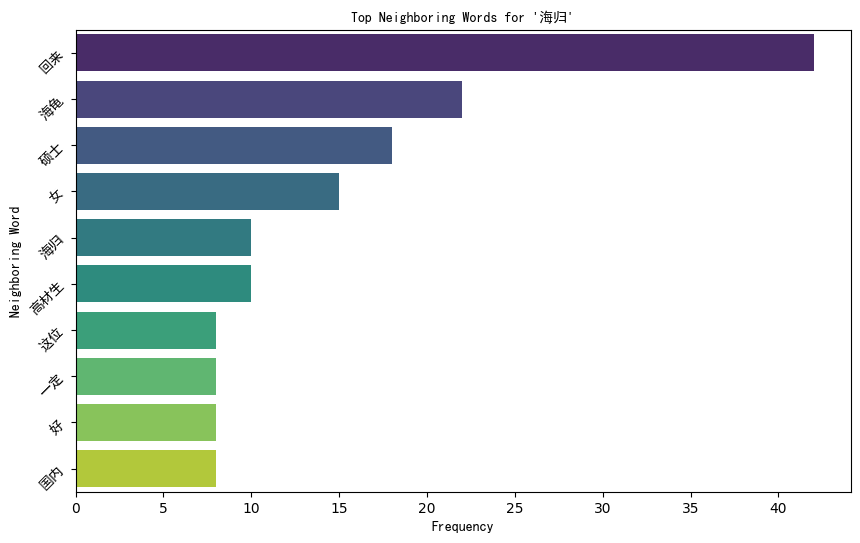

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
from matplotlib.font_manager import FontProperties

# Load the custom font
font_path = '/content/gdrive/MyDrive/SOC2070/research paper/return_migrant_project/font/SimHei.ttf'
font_prop = FontProperties(fname=font_path)

# Set the global font properties
plt.rcParams['font.family'] = font_prop.get_name()

# Define the function to get neighboring words
def get_neighbor_words(target_word, bigram_counts):
    neighbors = [word2 if word1 == target_word else word1
                 for (word1, word2) in bigram_counts if target_word in (word1, word2)]
    return Counter(neighbors).most_common()

# Example usage
neighbors_of_haigui = get_neighbor_words("海归", all_bigrams)

# Convert the results to a DataFrame for easy plotting
df_neighbors = pd.DataFrame(neighbors_of_haigui, columns=['Word', 'Frequency'])

# Plot the top 10 neighbors for visualization
plt.figure(figsize=(10, 6))
sns.barplot(x="Frequency", y="Word", data=df_neighbors.head(10), palette="viridis")

# Set the title and labels
plt.title("Top Neighboring Words for '海归'", fontproperties=font_prop)
plt.xlabel("Frequency", fontproperties=font_prop)
plt.ylabel("Neighboring Word", fontproperties=font_prop)
plt.yticks(rotation=45, fontproperties=font_prop)

# Show the plot
plt.show()
